<h1>Clasificador Naive-Bayes</h1>
En este notebook vamos a hacer un clasificador Naive-Bayes que se encargará de recomendarnos si hay que comprar piso o alquilar segun una serie ed características. <br>
Este recomendador utiliza <a href ="https://es.wikipedia.org/wiki/Teorema_de_Bayes">el teorema de Bayes</a> para tomar decisiones.

Importamos las librerias Python necesarias.

In [49]:
# Hacemos los imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import  SelectKBest

Definimos las constantes

In [50]:
# Declaramos las constantes que utilizaremos

CSV_FILE = './data/comprar_alquilar.csv'
N_FIRST_ROWS = 10
N_BEST_COLUMNS = 5

Cargamos el fichero CSV

In [51]:
dataFrame = pd.read_csv(CSV_FILE)

Imprimimos un resumen  estadístico de los datos.

In [52]:
dataFrame.describe()

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,971.584158,211.742574,515.425743,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683
std,1682.862556,272.106351,124.940754,168.103075,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988
min,2008.000000,384.000000,0.000000,201.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000
25%,3513.750000,766.750000,99.000000,383.250000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000
50%,4947.500000,968.000000,208.500000,522.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000
75%,6374.500000,1165.250000,318.750000,656.750000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000
max,7984.000000,1585.000000,448.000000,828.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000


Imprimimos las N primeras Rows.

In [53]:
print(f"{dataFrame.head(N_FIRST_ROWS)}")

   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   
5      5692             911          11           325    50875    360863   
6      6830            1298         345           309    46761    429812   
7      6470            1035          39           782    57439    606291   
8      6251            1250         209           571    50503    291010   
9      6987            1258         252           245    40611    324098   

   estado_civil  hijos  trabajo  comprar  
0             0      2        2        1  
1             1      3        6        0  
2             2      1        8   

A continuación, la leyenda de los datos: <br>
Estado_civil
<ol>
    <li>Soltero</li>
    <li>Casado</li>
    <li>Divorcido</li>
</ol>
Trabajo:
<ol>
    <li>Sin empleo</li>
    <li>Autónomo (freelance)</li>
    <li>Empleado</li>
    <li>Empresario</li>
    <li>Pareja: Autónomos</li>
    <li>Pareja: Empleados</li>
    <li>Pareja: Autónomo y asalariado</li>
    <li>Pareja: Empresario y autónomo</li>
    <li>Pareja: Empresario los 2 o empresario y empleado</li> 
</ol>
Comprar:
<ol>
    <li>No comprar</li>
    <li>Comprar</li>
</ol>

Para hacernos una idea de los datos que tenemos, pintaremos los histogramas de los datos que nos pasan.

array([[<Axes: title={'center': 'ingresos'}>,
        <Axes: title={'center': 'gastos_comunes'}>,
        <Axes: title={'center': 'pago_coche'}>],
       [<Axes: title={'center': 'gastos_otros'}>,
        <Axes: title={'center': 'ahorros'}>,
        <Axes: title={'center': 'vivienda'}>],
       [<Axes: title={'center': 'estado_civil'}>,
        <Axes: title={'center': 'hijos'}>,
        <Axes: title={'center': 'trabajo'}>]], dtype=object)

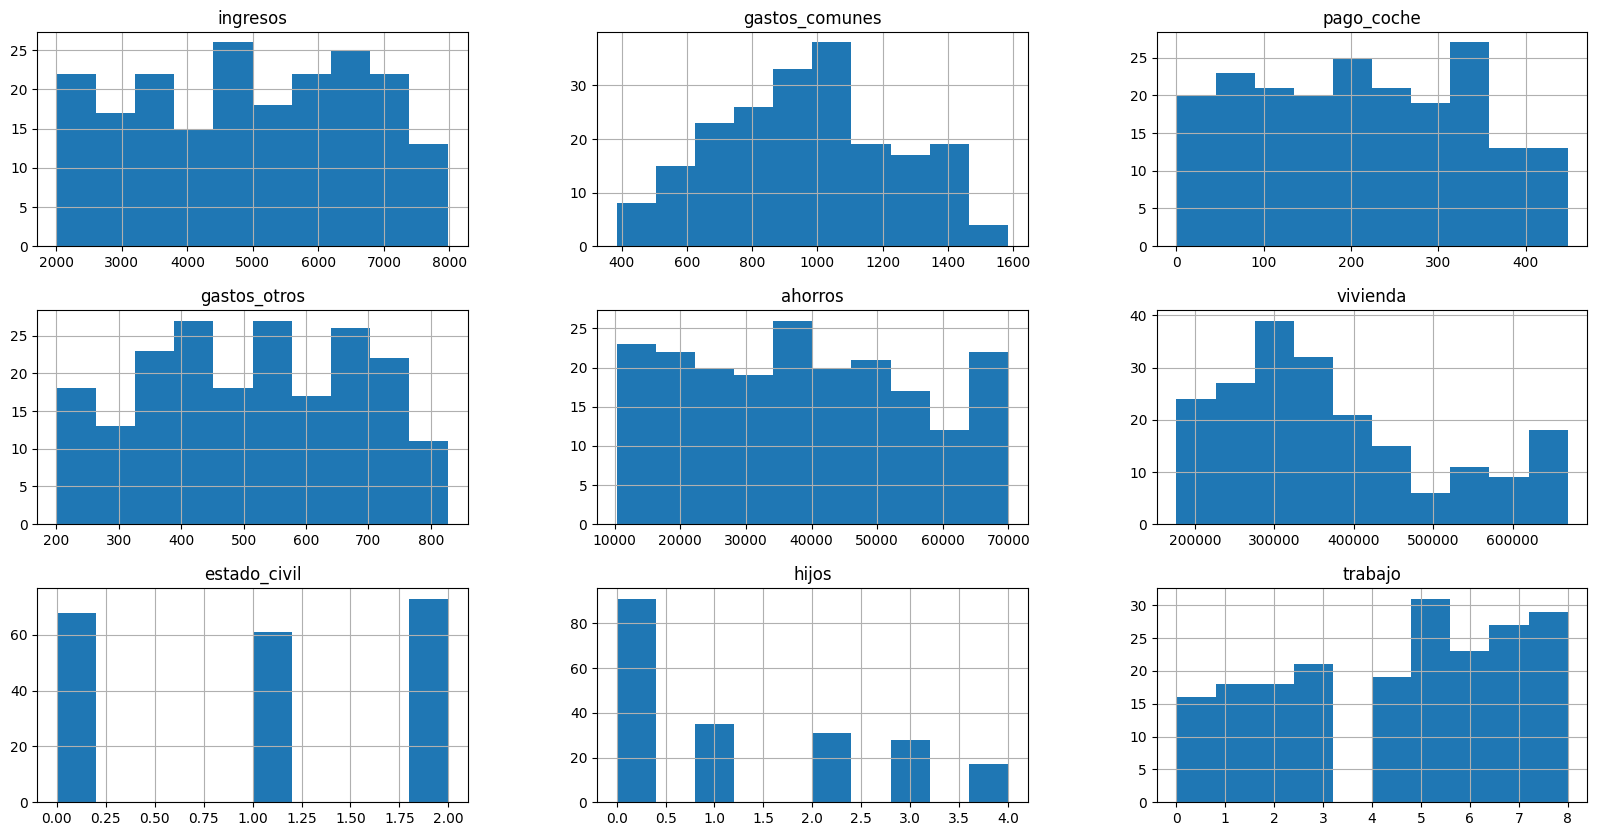

In [54]:
dataFrame.drop(['comprar'], axis = 'columns').hist(figsize=(20,10))

Podemos agrupar varias columnas , como por ejemplo todas las columnas de gasto y todas las columnas de ingresos.

In [55]:
# Creamos una nueva columna de   gastos que agruegue todas las columnas al respecto.abs
dataFrame['gastos'] = (dataFrame['gastos_comunes'] + dataFrame['gastos_otros'] + dataFrame['pago_coche'])

Creamos una columna adicional inversion que será la cantidad de dinero que ha de pedir prestado. Para ello restaremos los ahorros del precio de la vivienda que quiere comprar.

In [56]:
# Creamos la nueva columna inversion  que será la diferencia entre el precio de la vivienda y el ahorro de la familia
dataFrame['inversion'] = (dataFrame['vivienda'] - dataFrame['ahorros'])

Ahora vemos como queda el DataFrame

In [57]:
print(f"{dataFrame.head(N_FIRST_ROWS)}")

   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   
5      5692             911          11           325    50875    360863   
6      6830            1298         345           309    46761    429812   
7      6470            1035          39           782    57439    606291   
8      6251            1250         209           571    50503    291010   
9      6987            1258         252           245    40611    324098   

   estado_civil  hijos  trabajo  comprar  gastos  inversion  
0             0      2        2        1    1600     350000  
1             1      3        6        

Tenemos 11 columnas pero para  tener mejores resultados, seleccionaremos las 5 mejores caracteristicas para poder elegir. Estas N columnas serán las que más información aportan a la hora de   clasificar, es decir las que más influyen para clasificar un elemento en una u otra columna.

PAra ello  usaremos la funcion: SelectKBest() que nos devuelve  las N mejores columnas.

In [58]:
# Separamos las caracteristicas de las clasificaciones.
X = dataFrame.drop(['comprar'], axis = 'columns')
y = dataFrame['comprar']

best = SelectKBest(k = N_BEST_COLUMNS)
X_new = best.fit_transform(X, y)
selected = best.get_support(indices = True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'inversion'], dtype='object')


Ahora  que tenemos las N columnas que más aportan a la hora de decidir la clase, pintamos la matriz de correlacion entre ellas.

<Axes: title={'center': 'Correlacion de Pearson entre  las N features '}>

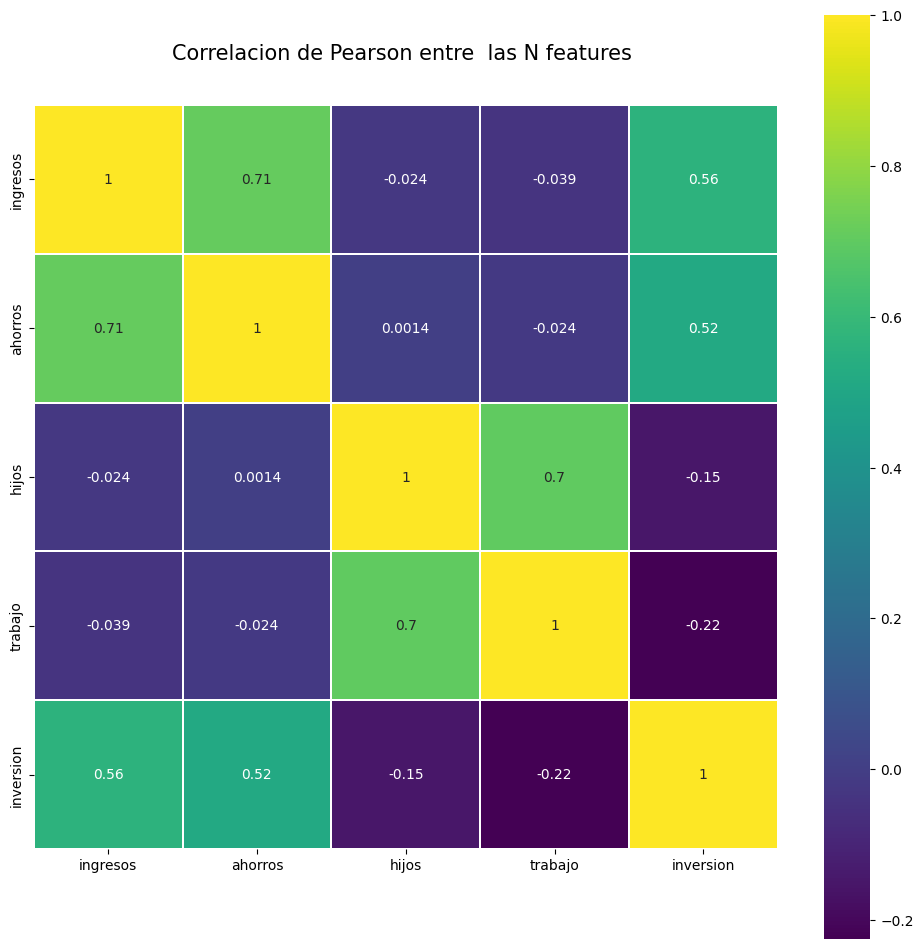

In [59]:
used_features = X.columns[selected]
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title("Correlacion de Pearson entre  las N features ", y = 1.05, size = 15)
# Creamos un mapa de calor para poder visualizar mejor la correlacion entre caracteristicas.
sb.heatmap(
    dataFrame[used_features].astype(float).corr(),
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True
    )


Y por curiosidad, vamos a printar la misma matriz de correlacion pero con las 11 columnas.

<Axes: title={'center': 'Correlacion de Pearson entre  las 11 features '}>

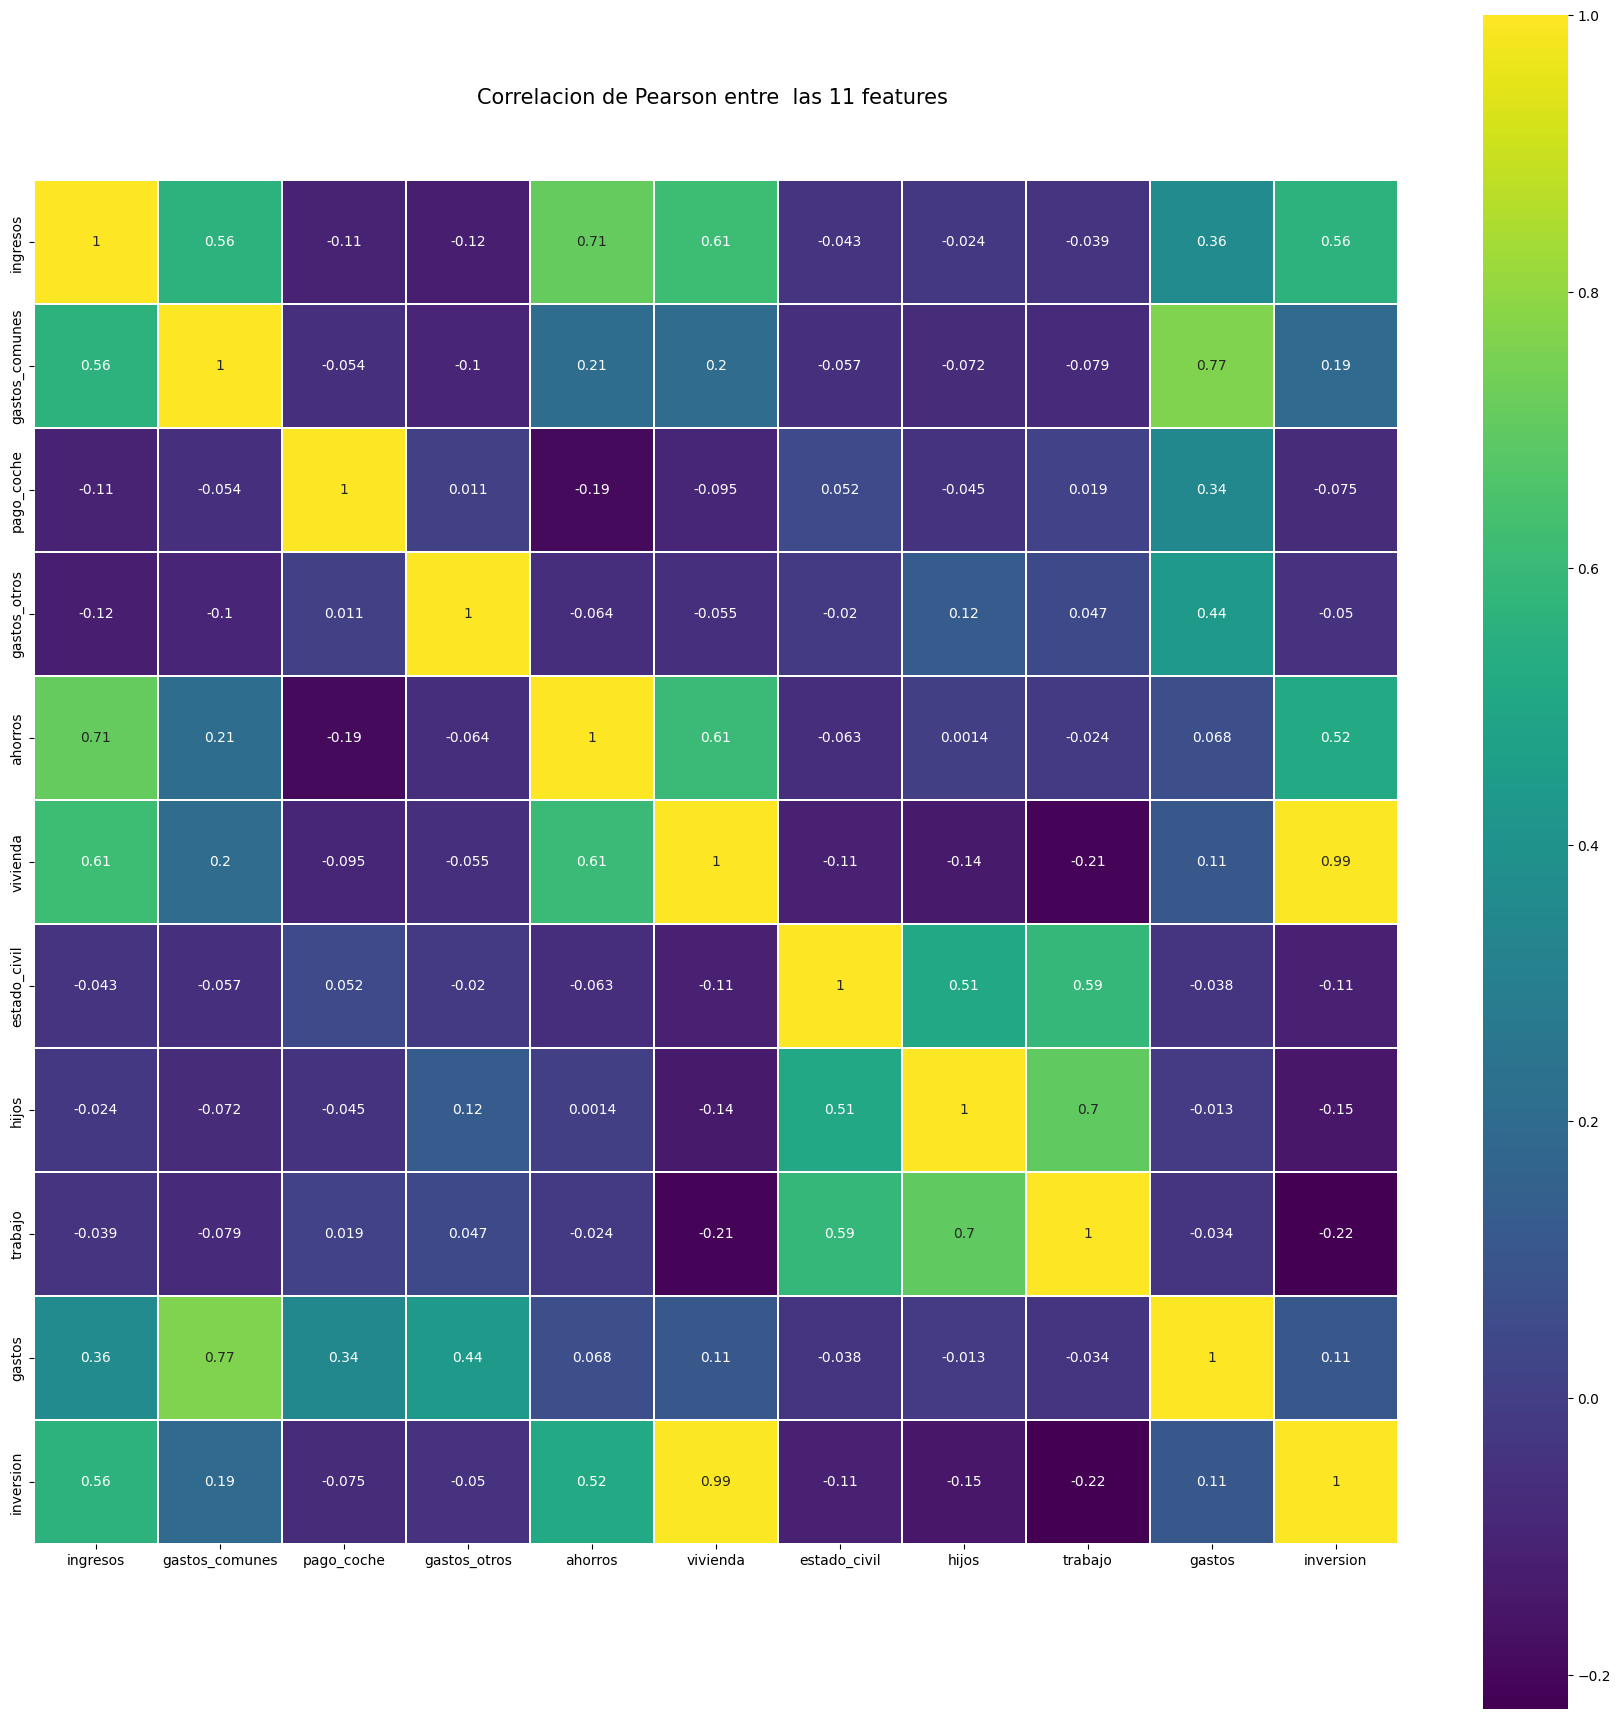

In [60]:
#used_features = X.columns[selected]
colormap = plt.cm.viridis
plt.figure(figsize=(22,22))
plt.title("Correlacion de Pearson entre  las 11 features ", y = 1.05, size = 15)
# Creamos un mapa de calor para poder visualizar mejor la correlacion entre caracteristicas.
sb.heatmap(
    dataFrame.drop(['comprar'], axis= 'columns').astype(float).corr(),
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True
    )


<h2>Creamos el modelo de clasificación con las N columnas más importantes.</h2><br>
Primero creamos el juego de entreno y el de test.

In [61]:
X_train, X_test = train_test_split(dataFrame, test_size = 0.2, random_state= 6)
y_train = X_train['comprar']
y_test = X_test['comprar']

Creamos el modelo...

In [66]:
gnb = GaussianNB()
# Entrenamos el modelo
gnb.fit(
    X_train[used_features].values,
    y_train
)
# Check de la precision del modelo.
y_pred = gnb.predict(X_test[used_features].values)
print(f"Precision del set de Entrenamiento: {gnb.score(X_train[used_features].values, y_train):.2f}")
print(f"Precision del set de Test: {gnb.score(X_test[used_features].values, y_test):.2f}")

Precision del set de Entrenamiento: 0.87
Precision del set de Test: 0.90


Hacemos una predicción de un individuo, si le conviene más comprar o alquilar...

In [69]:
print(gnb.predict([
    [2000,5000,0,5,200000],
    [6000,34000,2,5,320000]]
    ))
# Recuerda, 0 es alquilar y 1 comprar!

[0 1]
